Тамбовцев Р.И.
2021-05-17

Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

1. Импорт библиотек:

In [332]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [333]:
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

2. Расположение файлов и загрузка данных:

In [334]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

train_df.shape, test_df.shape


((10000, 19), (5000, 18))

In [335]:
train_df.head()  # первые пять строк dataset train.csv

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,nan,0,11,B,"184,966.93"
15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [336]:
test_df.head() # первые пять строк dataset test.csv

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,nan,0,0,B
15856,74,2.00,69.26,nan,1.00,6,1.00,1977,0.08,B,B,6,1437,3,nan,0,2,B
5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,"4,702.00",5,5,B
15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,nan,3,3,B
14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,nan,0,0,A


**Описание датасета:**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

3. Типы данных:

In [337]:
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Преобразование категории DistrictID в строковой тип, так как этот показатель не влияет на стоимость квартиры:

In [338]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [339]:
print(train_df.dtypes['DistrictId'])


object


4. Обзор данных

Целеая перменная 'Price' в обучающем DS:

Text(0.5, 1.0, 'Распределение целевой переменной')

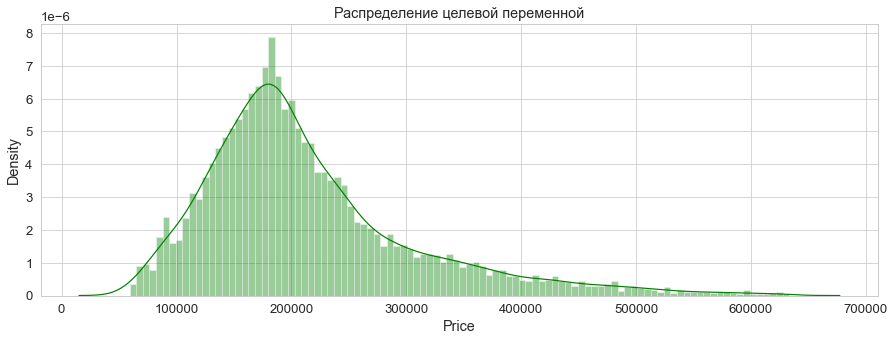

In [340]:
plt.figure(figsize=(15, 5))

sns.distplot(train_df['Price'], bins = 100, color = 'green') 
plt.title('Распределение целевой переменной') # Наименование графика

Подсчёт уникальных значений в обучающем DS:

In [341]:
train_df.nunique()

DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

Основные статистические данные:

In [342]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,"10,000.00","10,000.00","7,887.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","5,202.00","10,000.00","10,000.00","10,000.00"
mean,1.89,56.32,37.20,6.27,8.53,12.61,"3,990.17",0.12,24.69,"5,352.16",8.04,"1,142.90",1.32,4.23,"214,138.86"
std,0.84,21.06,86.24,28.56,5.24,6.78,"200,500.26",0.12,17.53,"4,006.80",23.83,"1,021.52",1.49,4.81,"92,872.29"
min,0.00,1.14,0.37,0.00,1.00,0.00,"1,910.00",0.00,0.00,168.00,0.00,0.00,0.00,0.00,"59,174.78"
25%,1.00,41.77,22.77,1.00,4.00,9.00,"1,974.00",0.02,6.00,"1,564.00",0.00,350.00,0.00,1.00,"153,872.63"
50%,2.00,52.51,32.78,6.00,7.00,13.00,"1,977.00",0.08,25.00,"5,285.00",2.00,900.00,1.00,3.00,"192,269.64"
75%,2.00,65.90,45.13,9.00,12.00,17.00,"2,001.00",0.20,36.00,"7,227.00",5.00,"1,548.00",2.00,6.00,"249,135.46"
max,19.00,641.07,"7,480.59","2,014.00",42.00,117.00,"20,052,011.00",0.52,74.00,"19,083.00",141.00,"4,849.00",6.00,23.00,"633,233.47"


По этим данным можно отметить несколько значений с которыми надо работать:
  *  ** - минимальные значения (min) общей и жилой площади - 1.14, 1,37;
  *  ** - максимальные значения (max) общей, жилой и площади кухни - 641.07, 7 480.59, 2 014.00;
  *  ** - расхождение между максимальной высотой здания и максимальным значением этажа квартиры - 117 и 42
  *  ** - явная ошибка в годе постройки в max значении;
  *  ** и т.д.

Определим количественные параметры для их последующей оценки с помощью гистограмм:

In [343]:
feature_num_names = train_df.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_num_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

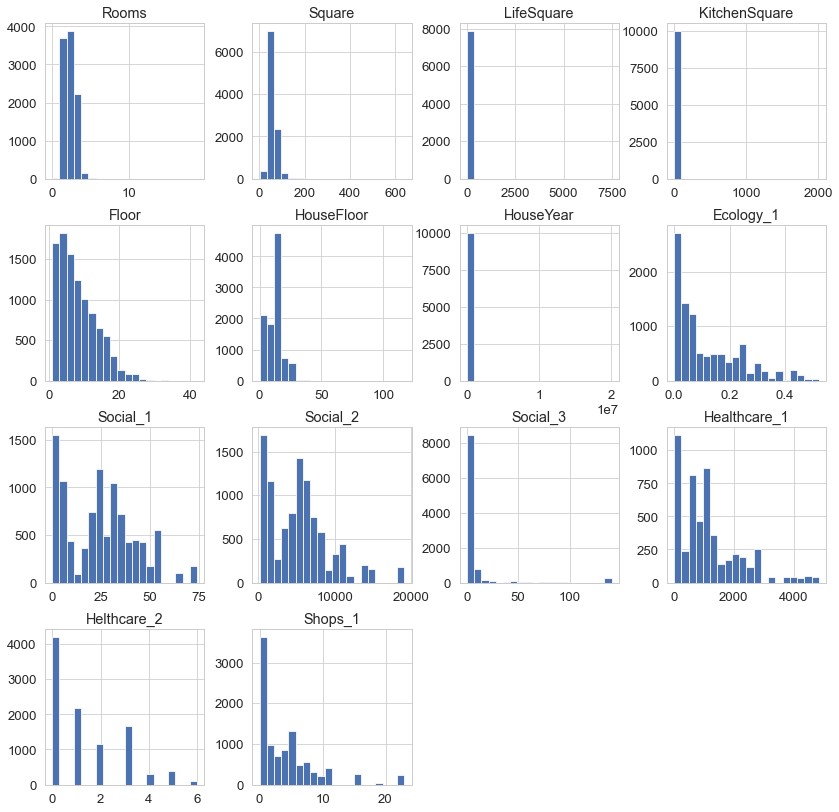

In [344]:
train_df[feature_num_names].hist(figsize=(14,14), bins=20, grid=True); # Гистограмма количественных параметров

Определим категориальные параметры для их последующей оценки с помощью boxplot (ящик с усами):

In [345]:
feature_cat_names = train_df.select_dtypes(include='object').columns.tolist()
feature_cat_names

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [346]:
train_df['Ecology_2'].value_counts() # типы и количество переменных в категории Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64

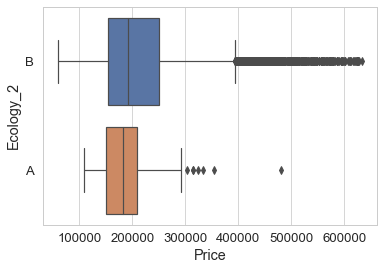

In [347]:
sns.boxplot('Price', 'Ecology_2', data=train_df); # оценка влияния категорий А и В в параметре Ecology_2 на Price

In [348]:
train_df['Ecology_3'].value_counts() # типы и количество переменных в категории Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64

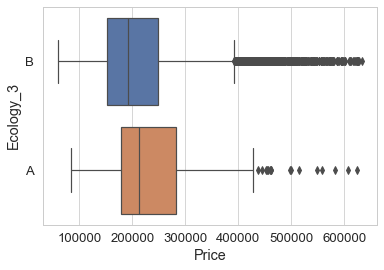

In [349]:
sns.boxplot('Price', 'Ecology_3', data=train_df); # оценка влияния категорий А и В в параметре Ecology_2 на Price

In [350]:
train_df['Shops_2'].value_counts() # типы и количество переменных в категории Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64

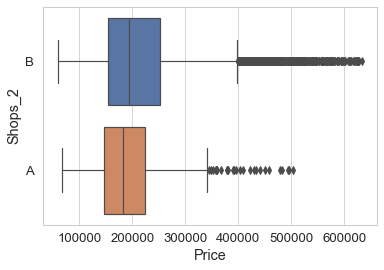

In [351]:
sns.boxplot('Price', 'Shops_2', data=train_df); # оценка влияния категорий А и В в параметре Shops_2 на Price

Так как модели из текущего курса обучения не работают со строками, то меняем категорийные признаки на числовые (бинарные) (А=0, В=1) в обоих DS, train и test:

In [352]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int64  
 18  Pri

5. Работа с пропусками

In [353]:
train_df.isna().sum()[train_df.isna().sum() !=0] # сумма пустых ячеек у параметров

LifeSquare      2113
Healthcare_1    4798
dtype: int64

* LifeSquare - заменим пустые значения по формуле:

In [354]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = (train_df['Square'] - train_df['KitchenSquare']) * 0.8
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = (test_df['Square'] - test_df['KitchenSquare']) * 0.8

In [355]:
train_df.corr()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Rooms,1.00,0.66,0.15,0.01,-0.00,-0.03,-0.01,-0.03,-0.00,-0.01,0.08,0.07,0.01,0.04,0.06,0.05,-0.00,0.55
Square,0.66,1.00,0.23,0.01,0.11,0.08,-0.01,-0.06,0.03,0.02,-0.07,-0.04,0.04,-0.04,-0.02,0.02,-0.05,0.52
LifeSquare,0.15,0.23,1.00,-0.01,0.03,0.02,-0.00,-0.03,0.01,0.01,-0.06,-0.05,0.01,-0.05,-0.03,-0.01,-0.01,0.09
KitchenSquare,0.01,0.01,-0.01,1.00,-0.01,0.00,0.00,-0.01,0.00,-0.01,0.04,0.04,-0.02,0.01,0.04,0.01,-0.02,0.03
Floor,-0.00,0.11,0.03,-0.01,1.00,0.42,0.00,-0.02,0.05,0.03,-0.04,-0.02,-0.00,-0.14,-0.07,0.02,-0.01,0.13
HouseFloor,-0.03,0.08,0.02,0.00,0.42,1.00,-0.00,-0.00,0.06,0.01,-0.02,0.01,-0.01,-0.14,-0.07,0.03,0.05,0.09
HouseYear,-0.01,-0.01,-0.00,0.00,0.00,-0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,0.01,0.00,0.00,0.00
Ecology_1,-0.03,-0.06,-0.03,-0.01,-0.02,-0.00,0.00,1.00,-0.11,-0.22,0.03,0.01,-0.12,-0.04,0.03,-0.08,0.08,-0.06
Ecology_2,-0.00,0.03,0.01,0.00,0.05,0.06,0.00,-0.11,1.00,-0.02,-0.07,-0.01,0.01,-0.03,-0.08,0.05,0.02,0.02
Ecology_3,-0.01,0.02,0.01,-0.01,0.03,0.01,0.00,-0.22,-0.02,1.00,-0.04,0.01,0.01,-0.11,-0.13,0.00,-0.05,-0.05


* Healthcare_1 - заменим медианой:

In [356]:
train_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median(), inplace=True)
test_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median(), inplace=True)

* Работа с выбросами

-Rooms

In [357]:
train_df['Rooms'].value_counts() # статиститка по количеству комнат в train DS

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

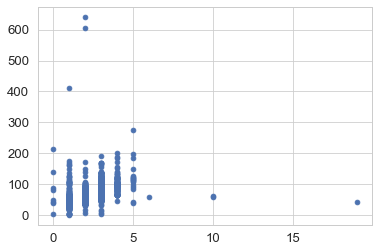

In [358]:
plt.scatter(train_df['Rooms'], train_df['Square']); # соотношение количества комнат к общей S квартиры в train DS

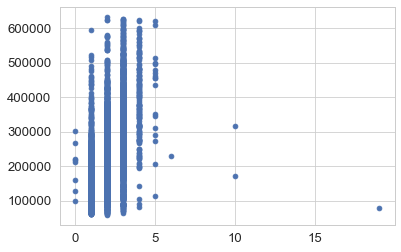

In [359]:
plt.scatter(train_df['Rooms'], train_df['Price']); # соотношение количества комнат к цене квартиры

In [360]:
test_df['Rooms'].value_counts() # статиститка по количеству комнат в test DS

2.00     2030
1.00     1769
3.00     1099
4.00       90
5.00        7
0.00        2
6.00        2
17.00       1
Name: Rooms, dtype: int64

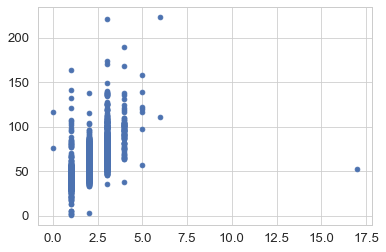

In [361]:
plt.scatter(test_df['Rooms'], test_df['Square']); # соотношение количества комнат к общей S квартиры в test DS

*Значения комнат более 5 и нулевые значения заменим на MODE

mode для количества комнат в train_df:

In [362]:
train_df['Rooms'].mode()[0]

2.0

In [363]:
train_df.loc[(train_df['Rooms'] > 5) | (train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0] # для train_df

test_df.loc[(test_df['Rooms'] > 5) | (test_df['Rooms'] == 0), 'Rooms'] = test_df['Rooms'].mode()[0]  # для test_df

-Square, LifeSquare, KitchenSquare

*Статистика по Square, LifeSquare, KitchenSquare

In [364]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.32,39.31,6.27
std,21.06,77.16,28.56
min,1.14,0.37,0.00
25%,41.77,25.00,1.00
50%,52.51,34.53,6.00
75%,65.90,47.53,9.00
max,641.07,"7,480.59","2,014.00"


In [365]:
train_df['KitchenSquare'].value_counts() # количесвто кухонь в разрезе метража

1.00      2460
8.00      1306
5.00      1169
10.00     1075
6.00      1038
          ... 
73.00        1
123.00       1
31.00        1
53.00        1
54.00        1
Name: KitchenSquare, Length: 58, dtype: int64

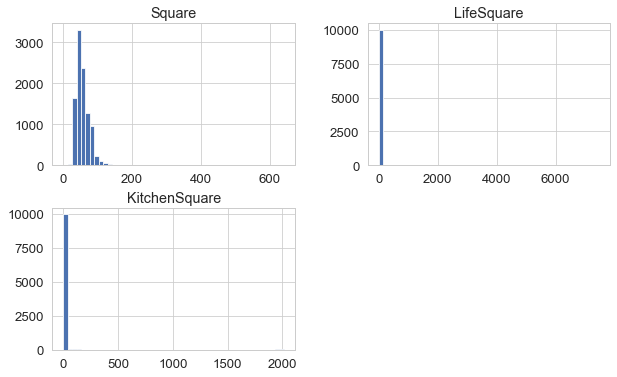

In [366]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].hist(figsize=(10,6), bins=50, grid=True);

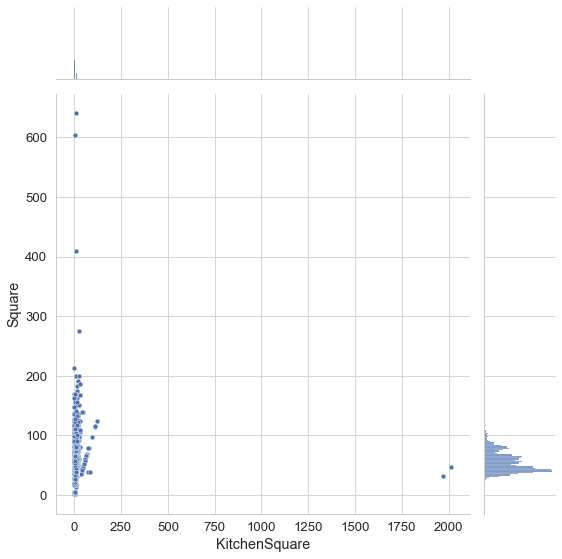

In [367]:
sns.jointplot(train_df['KitchenSquare'], train_df['Square'], kind='scatter', height=8);

*Замена части значений площади кухни в случае если она больше 150 или более общей площади на 25% от общей площади квартиры

In [368]:
train_df.loc[(train_df['KitchenSquare'] > 50) | \
             (train_df['KitchenSquare'] > train_df['Square']),
             'KitchenSquare'] = (train_df['Square'] * 0.25)

test_df.loc[(test_df['KitchenSquare'] > 50) | \
             (test_df['KitchenSquare'] > test_df['Square']),
             'KitchenSquare'] = (test_df['Square'] * 0.25)

*Работа с жилой площадью

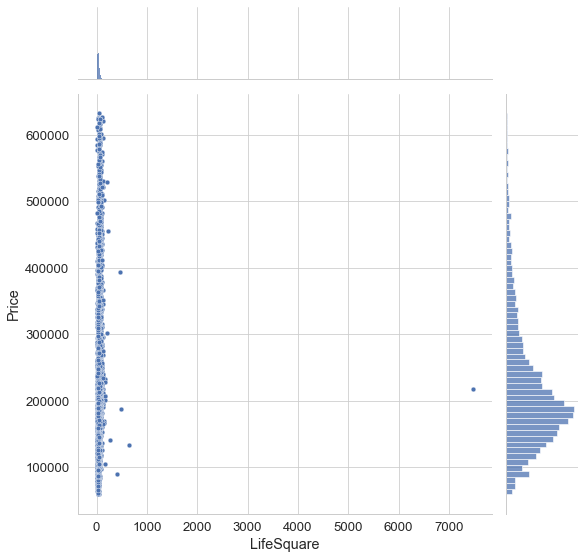

In [369]:
sns.jointplot(train_df['LifeSquare'], train_df['Price'], kind='scatter', height=8);

In [370]:
train_df.loc[(train_df['LifeSquare'] > 200) | \
             (train_df['LifeSquare'] > train_df['Square']) | \
             (train_df['LifeSquare'] < 5),
             'LifeSquare'] = (train_df['Square'] * 0.75)

test_df.loc[(test_df['LifeSquare'] > 200) | \
             (test_df['LifeSquare'] > test_df['Square']) | \
             (train_df['LifeSquare'] < 5),
             'LifeSquare'] = (test_df['Square'] * 0.75)

*Работа с общей площадью

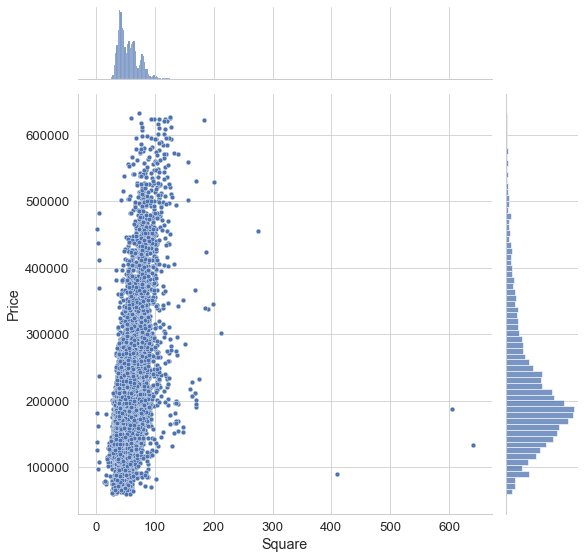

In [371]:
sns.jointplot(train_df['Square'], train_df['Price'], kind='scatter', height=8);

In [372]:
train_df.loc[(train_df['Square'] > 200), 'Square'] = train_df['Square'].median() # замена общей площади на медианное значение

test_df.loc[(test_df['Square'] > 200), 'Square'] = test_df['Square'].median() # замена общей площади на медианное значение

In [373]:
train_df.loc[(train_df['Square'] < 6), 'Square'] = (train_df['Square'] * 10) # замена общей площади на медианное значение

test_df.loc[(test_df['Square'] > 200), 'Square'] = (test_df['Square'] * 10) # замена общей площади на медианное значение

In [374]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.15,38.33,5.77
std,18.83,17.73,4.18
min,11.37,0.85,0.00
25%,41.78,26.12,1.00
50%,52.51,34.39,6.00
75%,65.88,47.23,9.00
max,198.93,480.80,48.00


*Этажность

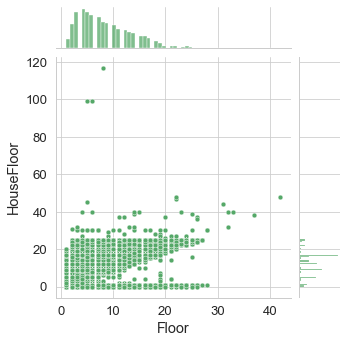

In [375]:
sns.jointplot(train_df['Floor'], train_df['HouseFloor'], kind='scatter', height=5, color='g');

In [376]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [377]:
train_df.loc[train_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] > 98, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

In [378]:
floor_outliers_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

floor_outliers_train

Int64Index([10953,  2119, 11935,  6486, 10521, 10103,  8443,  1063, 14675,
            14020,
            ...
            10361,  4660, 16050, 12590,  5071,  2237, 16159,  4145, 11553,
               77],
           dtype='int64', name='Id', length=1578)

In [379]:
train_df.loc[floor_outliers_train, 'Floor'] = \
    train_df.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x)) # замена этажа квартиры выше высоты дома, на случайный этаж не выше этажа дома
test_df.loc[floor_outliers_test, 'Floor'] = \
    test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

*Год постройки дома

In [380]:
train_df['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
6731         2020
8892         2020
14318        2020
           ...   
7920         1916
6751         1914
2085         1912
14556        1912
13288        1910
Name: HouseYear, Length: 10000, dtype: int64

*Замена двух значений года на корректные:

In [381]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011

*Работа с редкими категориями
Discrict

In [382]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size # популярность районов

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,196,1
201,209,1
202,205,1
203,117,1


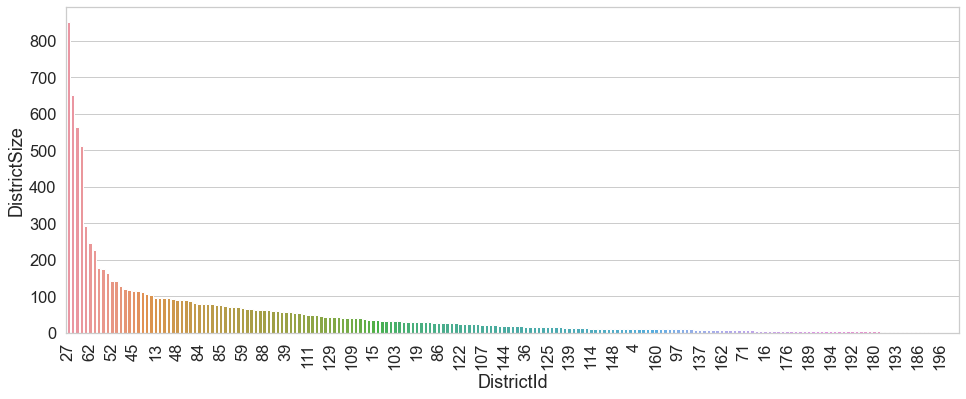

In [383]:
sns.set(style="whitegrid", font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y='DistrictSize', x='DistrictId', 
            data=district_size,
            order=district_size.sort_values(by='DistrictSize', ascending=False)['DistrictId']
           );
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(50))

In [384]:
districts_popular = district_size.loc[district_size['DistrictSize'] > 100, :] # районы с кол-ом квартир более 100
districts_popular

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
5,62,247
6,30,228
7,58,179
8,53,174
9,21,165


*Объединим районы с количеством квартир менее 100 в каждом в один с номером - 999

In [385]:
districts_popular = district_size.loc[district_size['DistrictSize'] > 100, 'DistrictId'].tolist()

In [386]:
district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                            DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)
district_size

,DistrictId,DistrictSize
0,999,15
1,1,652
2,11,129
3,21,165
4,23,565
5,27,851
6,30,228
7,34,111
8,44,104
9,45,116


In [387]:
train_df.loc[~train_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
test_df.loc[~test_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [388]:
test_df['DistrictId'].value_counts()

999    2551
27      391
1       344
23      264
6       257
9       132
62      122
30      115
58       91
53       91
21       70
52       67
61       64
8        64
46       61
34       61
74       61
57       54
45       49
44       46
11       45
Name: DistrictId, dtype: int64

Создание новых признаков. DistrictSize - Размер района

In [389]:
train_df = train_df.merge(district_size, on='DistrictId', how='left').set_index(train_df.index)
test_df = test_df.merge(district_size, on='DistrictId', how='left').set_index(test_df.index)

PriceOneRoom - Стоимость одной комнаты

In [390]:
train_df['PriceOneRoom'] = train_df['Price'] / train_df['Rooms']

PriceOneRoomByDistrict - Стоимость одной комнаты в зависимости от района

In [391]:
price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'PriceOneRoom':'median'})\
                        .rename(columns={'PriceOneRoom':'PriceOneRoomByDistrict'})

train_df = train_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)

RoomSquare - Площадь одной комнаты

In [392]:
train_df['RoomSquare'] = train_df['LifeSquare'] / train_df['Rooms']
test_df['RoomSquare'] = test_df['LifeSquare'] / test_df['Rooms']

Floor_cat - Категория этажа квартиры

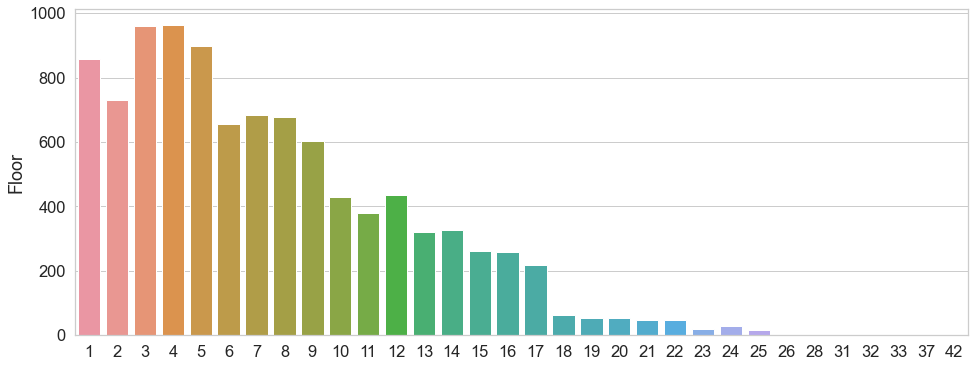

In [393]:
sns.set(style="whitegrid", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=train_df['Floor'].value_counts(), x=train_df['Floor'].value_counts().index);

In [394]:
train_df.loc[train_df['Floor'] <= 5, 'Floor_cat'] = 1  
train_df.loc[(train_df['Floor'] > 5) & (train_df['Floor'] <= 12), 'Floor_cat'] = 2
train_df.loc[train_df['Floor'] > 12, 'Floor_cat'] = 3

test_df.loc[test_df['Floor'] <= 5, 'Floor_cat'] = 1  
test_df.loc[(test_df['Floor'] > 5) & (test_df['Floor'] <= 12), 'Floor_cat'] = 2
test_df.loc[test_df['Floor'] > 12, 'Floor_cat'] = 3

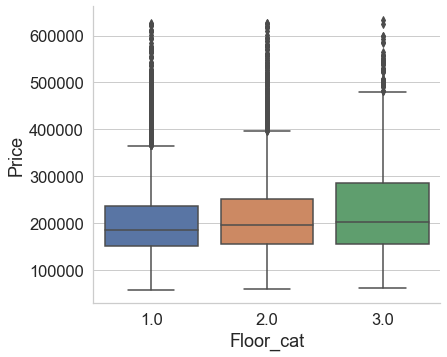

In [395]:
sns.catplot("Floor_cat", "Price", kind="box", data=train_df, aspect=5/4);

HouseFloor_cat - Категория этажности здания

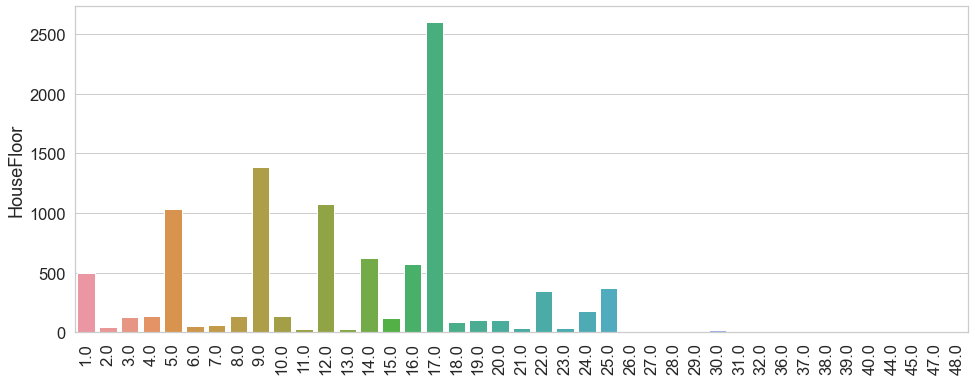

In [396]:
sns.set(style="whitegrid", font_scale=1.5)

f, ax = plt.subplots(figsize=(16, 6))
sns.barplot(y=train_df['HouseFloor'].value_counts(), 
            x=train_df['HouseFloor'].value_counts().index,
           )
ax.tick_params(axis='x', rotation=90);

In [397]:
train_df.loc[train_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
train_df.loc[(train_df['HouseFloor'] > 5) & (train_df['HouseFloor'] <= 12), 'HouseFloor_cat'] = 2
train_df.loc[train_df['HouseFloor'] > 12, 'HouseFloor_cat'] = 3

test_df.loc[test_df['HouseFloor'] <= 5, 'HouseFloor_cat'] = 1  
test_df.loc[(test_df['HouseFloor'] > 5) & (test_df['HouseFloor'] <= 12), 'HouseFloor_cat'] = 2
test_df.loc[test_df['HouseFloor'] > 12, 'HouseFloor_cat'] = 3

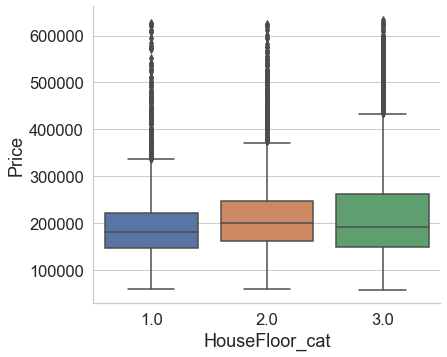

In [398]:
sns.catplot("HouseFloor_cat", "Price", kind="box", data=train_df, aspect=5/4);

StoreysFloor - Категория квартиры в зависимости от этажности здания и этажа квартиры

In [399]:
train_df[['Floor_cat', 'HouseFloor_cat']] = train_df[['Floor_cat', 'HouseFloor_cat']].astype(int)
test_df[['Floor_cat', 'HouseFloor_cat']] = test_df[['Floor_cat', 'HouseFloor_cat']].astype(int)

train_df['StoreysFloor'] = (train_df['HouseFloor_cat'].astype(str) + \
                            train_df['Floor_cat'].astype(str)).astype(int)
test_df['StoreysFloor'] = (test_df['HouseFloor_cat'].astype(str) + \
                            test_df['Floor_cat'].astype(str)).astype(int)

train_df['StoreysFloor'].value_counts()

32    2326
11    1837
33    1731
22    1536
21    1348
31    1222
Name: StoreysFloor, dtype: int64

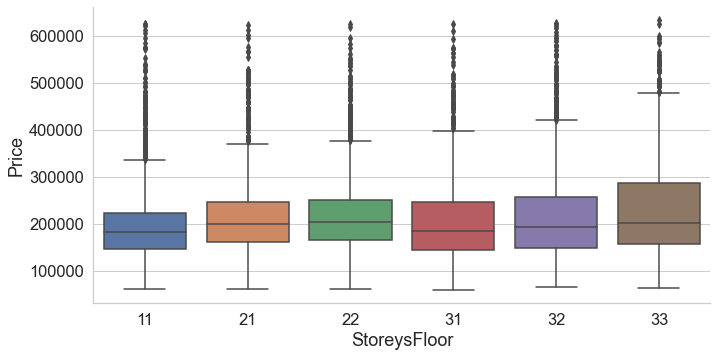

In [400]:
sns.catplot("StoreysFloor", "Price", kind="box", data=train_df, aspect=2/1);

PriceOneRoomByStoreysFloor - Стоимость одной комнаты в зависимости от категории `StoreysFloor`

In [401]:
price_by_floor_storeys = train_df.groupby(['StoreysFloor'], as_index=False)\
                    .agg({'PriceOneRoom':'median'})\
                    .rename(columns={'PriceOneRoom':'PriceOneRoomByStoreysFloor'})

In [402]:
train_df = train_df.merge(price_by_floor_storeys, on=['StoreysFloor'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_floor_storeys, on=['StoreysFloor'], how='left').set_index(test_df.index)

## Отбор признаков для обучения

In [403]:
target_name = ['Price']
feature_names = [
#             'DistrictId',
             'Rooms',
             'Square',
#             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
#             'Ecology_2',
#             'Ecology_3',
             'Social_1',
             'Social_2',
             'Social_3',
#             'Healthcare_1',
             'Helthcare_2',
             'Shops_1',
#             'Shops_2',
#             'Price',
             'DistrictSize',
#             'PriceOneRoom',
             'PriceOneRoomByDistrict',
             'RoomSquare',
             'Floor_cat',
             'HouseFloor_cat',
#             'StoreysFloor',
#             'PriceOneRoomByStoreysFloor'
]

In [404]:
X = train_df[feature_names]
y = train_df[target_name]

X_test = test_df[feature_names]

## Построение модели

Перекрестная проверка модели

In [405]:
forest = RandomForestRegressor(max_depth=19, 
                               max_features=5, 
                               n_estimators=400,
                               random_state=42)

In [406]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.74154


*Оценка важности признаков

In [407]:
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

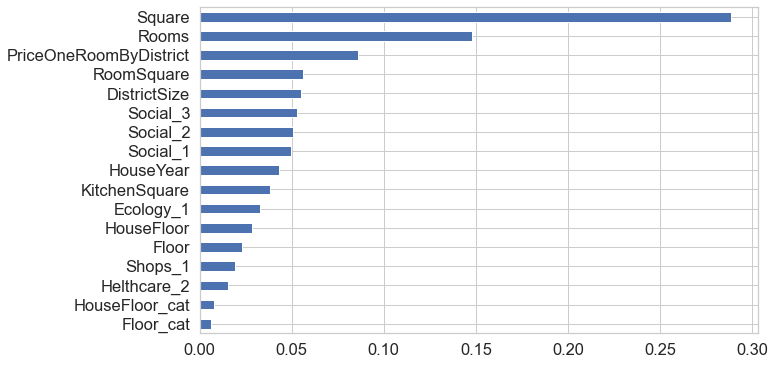

In [408]:
feat_importances.plot(kind='barh', figsize=(10, 6)); # RFE

Гиперпараметры модели

In [409]:
params = {
#    'n_estimators': [100],
    'max_depth': [14,16,18],
    'max_features': [4,5,6]
}

In [410]:
forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=3, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_)) # 0.74154

{'max_depth': 16, 'max_features': 5}
R2 на train: 0.73502


### Прогноз

In [411]:
forest_best = forest_grid.best_estimator_

y_pred = forest_best.predict(test_df[feature_names])

In [412]:
preds = pd.DataFrame()
preds['Id'] = test_df.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,"160,795.72"
1,15856,"230,402.09"
2,5480,"221,874.14"
3,15664,"338,552.22"
4,14275,"147,629.39"


In [414]:
preds.to_csv('CW_TambovtsevR_17_05_21.csv', index=False)